# Comment analysis
- Some search doesn't match properly: Praça Bartolomeu de Gusmão

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
import sqlite3
import os
import re
from datetime import datetime


In [10]:
print(os.getcwd(), os.listdir('./'))
os.chdir('./../')
print(os.getcwd(), os.listdir('./'))


/mnt/Datos/proyectospython/EspaciosVerdes/notebooks ['01_dowload_osm.ipynb', '02_scraping.ipynb', 'cache']
/mnt/Datos/proyectospython/EspaciosVerdes ['notebooks', 'criticas_parco_verde.csv', 'data', 'scripts', 'cache', 'venv', 'example.png', 'documents', '.gitignore', 'REAME.md']


In [11]:
NOME_DB = "data/raw/scrapcomments.db"
with sqlite3.connect(NOME_DB) as connection:
    df = pd.read_sql('SELECT * FROM googleplaces', connection)

In [25]:
df.shape

(1074, 5)

In [12]:
df.head()

,index,url,Estrellas,Fecha,Comentario
0,0,https://www.google.com/maps,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...
1,1,https://www.google.com/maps,5,há um mês,"Foi muito divertida, rir muito com minha mulhe..."
2,2,https://www.google.com/maps,4,há um ano,Um sitio para quem mora perto fazer uma patusc...
3,3,https://www.google.com/maps,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ..."
4,4,https://www.google.com/maps,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...


In [ ]:
# 1074 - 679 = 395 Duplicates
df = df.drop_duplicates(subset=['url', 'Comentario'])

# Explore data

In [34]:
df['Estrellas'].value_counts()

Estrellas
5    347
4    196
3     94
1     22
2     20
Name: count, dtype: int64

In [42]:
df.dtypes

index                       int64
url                        object
Estrellas                   int64
Fecha                      object
Comentario                 object
Fecha_Calculada    datetime64[ns]
dtype: object

In [33]:
df['url']

0      https://www.google.com/maps
1      https://www.google.com/maps
2      https://www.google.com/maps
3      https://www.google.com/maps
4      https://www.google.com/maps
                  ...             
989    https://www.google.com/maps
990    https://www.google.com/maps
991    https://www.google.com/maps
992    https://www.google.com/maps
993    https://www.google.com/maps
Name: url, Length: 679, dtype: object

# Time series analysis

In [35]:
df['Fecha'].value_counts()

Fecha
há 6 anos              120
há 3 anos               84
há 2 anos               81
há 4 anos               63
há 7 anos               57
há um ano               53
há 8 anos               48
há 5 anos               34
Editado há 6 anos       15
há 3 meses              14
há um mês               13
há 9 anos               10
há 4 meses              10
Editado há 3 anos        9
há 5 meses               8
Editado há 2 anos        8
há 2 meses               7
há 7 meses               6
Editado há 4 anos        6
Editado há 5 anos        5
Editado há 7 anos        4
Editado há um ano        3
Editado há 8 anos        3
há 8 meses               3
há 10 meses              2
há 2 semanas             2
há uma semana            2
há 9 meses               2
há 11 meses              2
Editado há 6 meses       1
há 3 semanas             1
Editado há 10 meses      1
há 6 meses               1
há 10 anos               1
Name: count, dtype: int64

In [ ]:
# Mapping words
MAPA_TIEMPO = {
    'years': ['ano', 'anos', 'año', 'años'],
    'months': ['mês', 'meses', 'mes'],
    'weeks': ['semana', 'semanas'],
    'days':   ['dia', 'dias', 'día', 'días'],
    'hours':  ['hora', 'horas'],  # Extra: por si aparecen horas
}

def convertir_fecha_dinamica(texto):
    """
    Convierte texto como 'há 6 anos' en un objeto datetime real
    usando extracción dinámica de números y unidades.
    """
    # 1. Normalización básica
    if pd.isna(texto): return pd.NaT
    # Pasamos a minúsculas y limpiamos espacios
    t = str(texto).lower().strip()
    
    # Fecha base (Hoy) normalizada a las 00:00:00
    hoy = pd.Timestamp.now().normalize()

    # 2. Extracción del VALOR (Entero)
    cantidad = 0
    
    # Caso especial: palabras textuales como "um" o "uma"
    if 'um ' in t or 'uma ' in t: # Espacio para no confundir con 'algUMa'
        cantidad = 1
    else:
        # Regex: Busca cualquier secuencia de dígitos (\d+)
        coincidencia = re.search(r'(\d+)', t)
        if coincidencia:
            cantidad = int(coincidencia.group(1))
        else:
            return pd.NaT # Si no hay número ni 'um', no podemos calcular

    # 3. Detección de la UNIDAD (Dinámica)
    # Recorremos nuestro diccionario de configuración
    for unidad_pandas, palabras_clave in MAPA_TIEMPO.items():
        # Verificamos si alguna palabra clave está en el texto
        if any(palabra in t for palabra in palabras_clave):
            
            # 4. Cálculo Matemático (Magia de Pandas)
            # Creamos un diccionario dinámico con el parámetro correcto
            # Equivale a decir: DateOffset(years=6) o DateOffset(months=3)
            kwargs = {unidad_pandas: cantidad}
            return hoy - pd.DateOffset(**kwargs)

    # Si llegamos aquí, detectamos número pero no la unidad (ej: "há 6 ???")
    return pd.NaT


In [ ]:
# Apply custom function to extract time data
print("Calculando fechas...")
df['Fecha_Calculada'] = df['Fecha'].apply(convertir_fecha_dinamica)
df.head()

Calculando fechas...
     index                          url Estrellas              Fecha  \
0        0  https://www.google.com/maps         5          há um ano   
1        1  https://www.google.com/maps         5          há um mês   
2        2  https://www.google.com/maps         4          há um ano   
3        3  https://www.google.com/maps         2         há 5 meses   
4        4  https://www.google.com/maps         4          há 2 anos   
..     ...                          ...       ...                ...   
989      3  https://www.google.com/maps         4          há 2 anos   
990      4  https://www.google.com/maps         5          há 3 anos   
991      5  https://www.google.com/maps         5          há um ano   
992      6  https://www.google.com/maps         5  Editado há 3 anos   
993      7  https://www.google.com/maps         5          há 6 anos   

                                            Comentario Fecha_Calculada  
0    Um ótimo lugar para comer e uma tril

# Simple exploratory comments
## Word Cloud

In [17]:
# Descargamos las palabras vacías (solo la primera vez)
nltk.download('stopwords')

# Convertimos a string por si hay algún dato numérico suelto y eliminamos vacíos
df['Comentario'] = df['Comentario'].astype(str).fillna('')

# 2. DEFINIR STOPWORDS (Palabras a ignorar)
# Usamos la lista de español de NLTK y añadimos algunas propias que no aportan valor
stop_words_es = stopwords.words('portuguese')
# Añadimos palabras "basura" típicas de reviews que ensucian el gráfico
nuevas_stopwords = ['lar', 'sitio', 'ir', 'ver', 'mas', 'si', 'tan', 'parco', 'verde'] 
stop_words_es.extend(nuevas_stopwords)

[nltk_data] Downloading package stopwords to /home/bac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
def generar_nube(texto_completo, titulo):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        stopwords=stop_words_es,
        min_font_size=10
    ).generate(texto_completo)

    plt.figure(figsize=(10, 5), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(titulo, fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()

Generando Nube de Palabras General...


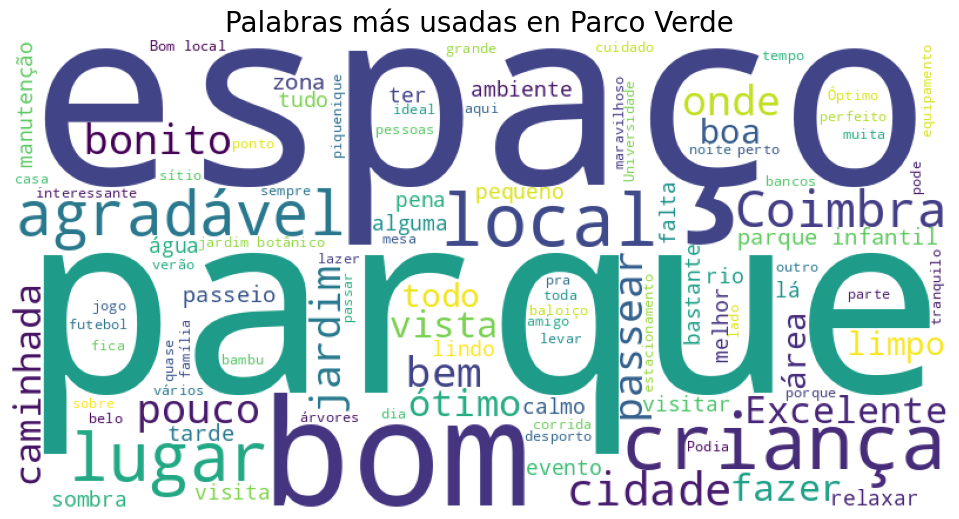

In [19]:
print("Generando Nube de Palabras General...")
texto_general = " ".join(review for review in df.Comentario)
generar_nube(texto_general, "Palabras más usadas en Parco Verde")

## B-Gram

In [22]:
def grafico_bigramas(corpus, n=10):
    # Usamos CountVectorizer para contar pares de palabras (ngram_range=(2,2))
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words_es).fit(corpus)
    bag_of_words = vec.transform(corpus)
    
    # Sumamos la frecuencia de palabras
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    # Ordenamos de mayor a menor frecuencia
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    # Tomamos el top N
    top_words = words_freq[:n]
    
    # Separamos para graficar
    x, y = zip(*top_words) # x=palabras, y=frecuencias
    
    plt.figure(figsize=(10, 6))
    plt.barh(x, y, color='skyblue')
    plt.gca().invert_yaxis() # Para que el más común salga arriba
    plt.title('Top 10 Pares de Palabras (Bigramas) más comunes')
    plt.xlabel('Frecuencia')
    plt.show()

Generando Gráfico de Bigramas...


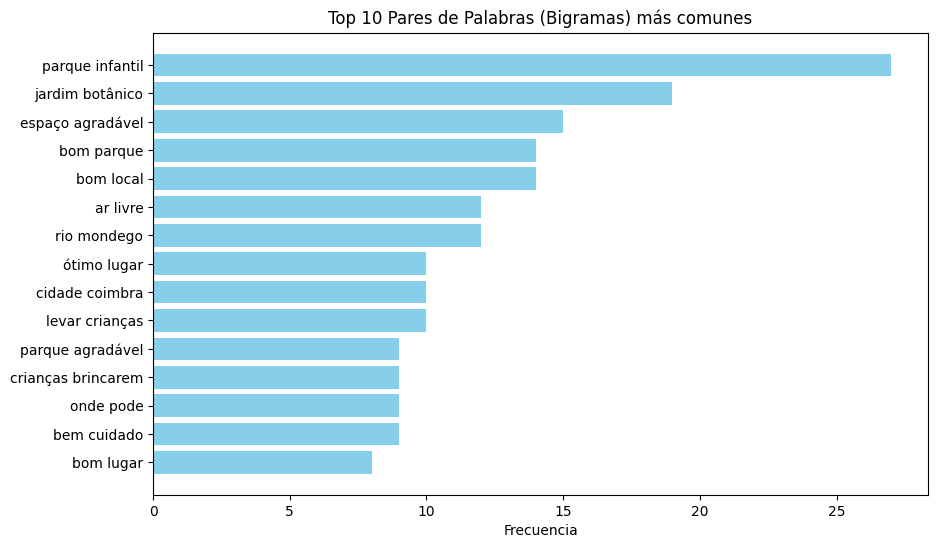

In [ ]:
print("Generando Bigramas...")
grafico_bigramas(df['Comentario'], n=15)

# Time series

In [36]:
df.head()

,index,url,Estrellas,Fecha,Comentario,Fecha_Calculada
0,0,https://www.google.com/maps,5,há um ano,Um ótimo lugar para comer e uma trilha excelen...,2024-12-01
1,1,https://www.google.com/maps,5,há um mês,"Foi muito divertida, rir muito com minha mulhe...",2025-11-01
2,2,https://www.google.com/maps,4,há um ano,Um sitio para quem mora perto fazer uma patusc...,2024-12-01
3,3,https://www.google.com/maps,2,há 5 meses,"Maltratado. Só placas de inaugurações, mas águ...",2025-07-01
4,4,https://www.google.com/maps,4,há 2 anos,Um bom parque com várias mesas cobertas e uma ...,2023-12-01


In [41]:
df['Estrellas'] = df['Estrellas'].astype(int)

In [43]:
analisis_temporal = df.groupby(pd.Grouper(key='Fecha_Calculada', freq='M')).agg({'Estrellas': 'mean'})
# Esto rellenará huecos. Si un mes no hubo reviews, aparecerá como NaN (puedes usar .fillna(0))
print(analisis_temporal)

                 Estrellas
Fecha_Calculada           
2015-12-31        4.000000
2016-01-31             NaN
2016-02-29             NaN
2016-03-31             NaN
2016-04-30             NaN
...                    ...
2025-07-31        4.500000
2025-08-31        4.100000
2025-09-30        4.571429
2025-10-31        4.428571
2025-11-30        4.277778

[120 rows x 1 columns]


/tmp/ipykernel_87104/2357727259.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  analisis_temporal = df.groupby(pd.Grouper(key='Fecha_Calculada', freq='M')).agg({'Estrellas': 'mean'})


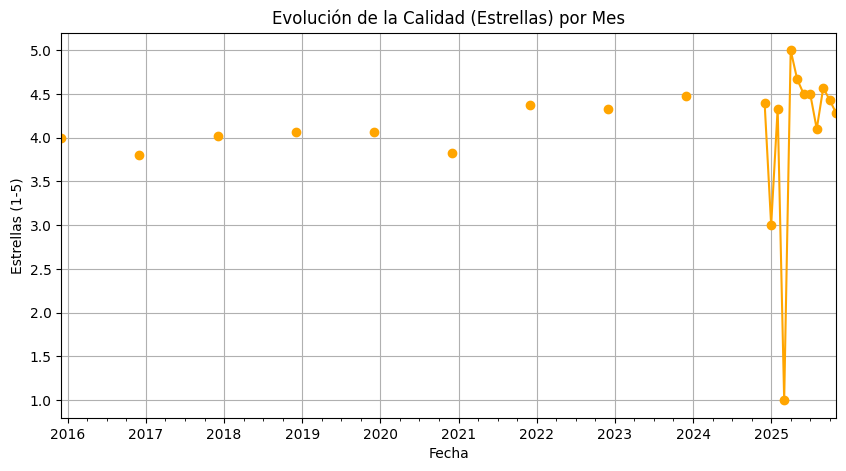

In [ ]:
# Graficamos el promedio de estrellas
analisis_temporal['Estrellas'].plot(kind='line', marker='o', color='orange', figsize=(10,5))

plt.title("Evolución de la Calidad (Estrellas) por Mes")
plt.ylabel("Estrellas (1-5)")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()

# Spatial comments analysis

In [ ]:
df

# END